# Results of human-LLM collaboration

Example notebook for the BrainGPT project

## Load libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

## Add labels to logistic prediction

In [2]:
# Set path to directories
root_path = '../data/'

# Load the results for all team member combinations on GPT-4 generated abstracts
logistic_results = pd.read_csv('../results/Logistic_predictions.csv')

# Set labels for the type of team
lab_H, lab_M, lab_HM = 'Human only', 'LLM only', 'Human-LLM'

# Set type of team
llms = list(logistic_results.iloc[:,1:-1].columns)
df = logistic_results.copy()
df['Classifier'] = df.iloc[:,1:-1].apply(lambda x: 'Human' if not x[llms].any() else '-'.join([col for col in llms if x[col]]), axis=1)
df['Type'] = df.iloc[:,:-2].apply(lambda x: lab_M if not x['Human'] else lab_HM if x.sum() > 1 else lab_H, axis=1)
df['Accuracy'] = df['Accuracy'] * 100

# Get number of observations
online_study = pd.read_csv(f"{root_path}human/data/participant_data.csv")
abstract_idx = online_study['journal_section'].str.startswith('machine')
n = online_study[abstract_idx].shape[0]

# Calculate error bars (sem binomial data) for each point
df['SE'] = df.apply(lambda x: np.sqrt(x['Accuracy'] * (100 - x['Accuracy']) / n), axis=1)

df

,Human,7B,13B,70B,Accuracy,Classifier,Type,SE
0,True,False,False,False,69.781312,Human,Human only,2.047497
1,False,True,False,False,72.564612,7B,LLM only,1.989454
2,False,False,True,False,72.564612,13B,LLM only,1.989454
3,False,False,False,True,74.552684,70B,LLM only,1.942087
4,True,True,False,False,78.528827,7B,Human-LLM,1.830874
5,True,False,True,False,80.318091,13B,Human-LLM,1.772786
6,True,False,False,True,79.522863,70B,Human-LLM,1.799271
7,False,True,True,False,76.540755,7B-13B,LLM only,1.889380
8,False,True,False,True,74.155070,7B-70B,LLM only,1.951974
9,False,False,True,True,75.546720,13B-70B,LLM only,1.916427


## Define helper function to plot results

In [3]:
def plot_figure(df, mycolors, mymarkers, mymarksze):
    # Set the style and font using matplotlib
    plt.rc('font', family='Arial')
    plt.rc('axes', grid=True)
    plt.rc('axes', facecolor='white')

    # Create a figure and a set of subplots
    fig, ax = plt.subplots(figsize=(8,4))

    # Font size
    fs = 16

    # Define the width of the dodge
    dodge_width = 0.125

    # Create a list of classifiers per type
    n_classifiers = np.arange(0, len(df['Classifier'].unique()))
    
    # Shift results if there is Human only team
    is_H_only = 0

    # Create error bars
    for i, type in enumerate(df['Type'].unique()):
        type_data = df[df['Type'] == type]
        if i==0 and lab_H in type:
            y_coords = n_classifiers.min()
            is_H_only = 1
        else:
            y_coords = n_classifiers[is_H_only:] + (i-0.5-is_H_only)*2*dodge_width
        ax.errorbar(type_data['Accuracy'], y_coords, xerr=type_data['SE'],
            fmt=mymarkers[type], markersize=mymarksze[type], capsize=0, color=mycolors[type],
            elinewidth=2, label=type)

    # Set x-axis limits
    ax.set_xlim([50, 100])
    ax.set_xticks([50, 60, 70, 80, 90, 100])
    ax.set_xlabel("Accuracy (%)", fontsize=fs)  # Rename the x-axis label

    # Reverse the y-axis
    ax.set_yticks(n_classifiers, df['Classifier'].unique())
    ax.set_ylim([n_classifiers.min()-0.5, n_classifiers.max()+0.5])
    ax.invert_yaxis()

    # Increase the size of the tick labels
    ax.tick_params(axis='both', which='major', labelsize=fs)

    # Show the legend
    legend_elements = [Line2D([0], [0], marker=mymarkers[type], color='w', label=type,
        markerfacecolor=mycolors[type], markersize=3+mymarksze[type], linestyle='None')
            for type in df['Type'].unique()]
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5,1.2),
        ncol=len(df['Type'].unique()), frameon=False, fontsize=fs)

    # Show the plot
    plt.show()

## Plot Figure 3

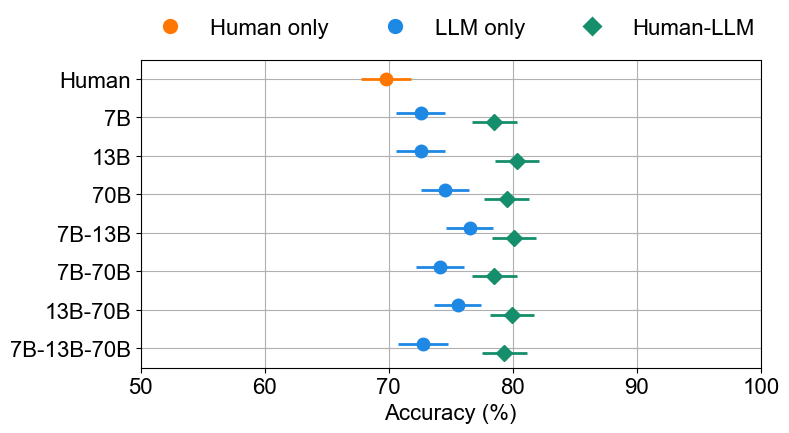

In [4]:
# Define custom colors for each type
mycolors  = {lab_H: '#FF7600', lab_M: '#1E88E5', lab_HM: '#158E6B'}
mymarkers = {lab_H: 'o',       lab_M: 'o',       lab_HM: 'D'}
mymarksze = {lab_H: 9,         lab_M: 9,         lab_HM: 8}

# Plot Figure 3
plot_figure(df, mycolors, mymarkers, mymarksze)

## Prepare human-LLM predictions for both models

In [5]:
# Load the results for human-LLM teams with the Bayesian Combination Model
b07 = pd.read_csv('../results/Bayesian_HM_predictions_7B.csv').mean() * 100
b13 = pd.read_csv('../results/Bayesian_HM_predictions_13B.csv').mean() * 100
b70 = pd.read_csv('../results/Bayesian_HM_predictions_70B.csv').mean() * 100

# Create a dataframe with the results
df2 = pd.DataFrame({'Accuracy': [b07['AB'], b13['AB'], b70['AB']], 
                    'Classifier': ['7B', '13B', '70B'], 
                    'Type': 'Bayesian'})

# Calculate error bars (sem binomial data) for each point
df2['SE'] = df2.apply(lambda x: np.sqrt(x['Accuracy'] * (100 - x['Accuracy']) / n), axis=1)

# Add results for the logistic model
df2 = pd.concat([df2, df.loc[(df['Type'] == lab_HM) & (df['Classifier'].isin(df2['Classifier'])), df2.columns]])
df2['Type'] = df2['Type'].replace(lab_HM, 'Logistic')

# Update classifier names
df2['Classifier'] = 'Human-' + df2['Classifier']

df2

,Accuracy,Classifier,Type,SE
0,72.962227,Human-7B,Bayesian,1.980389
1,72.166998,Human-13B,Bayesian,1.998321
2,76.341948,Human-70B,Bayesian,1.894904
4,78.528827,Human-7B,Logistic,1.830874
5,80.318091,Human-13B,Logistic,1.772786
6,79.522863,Human-70B,Logistic,1.799271


## Plot Figure 4

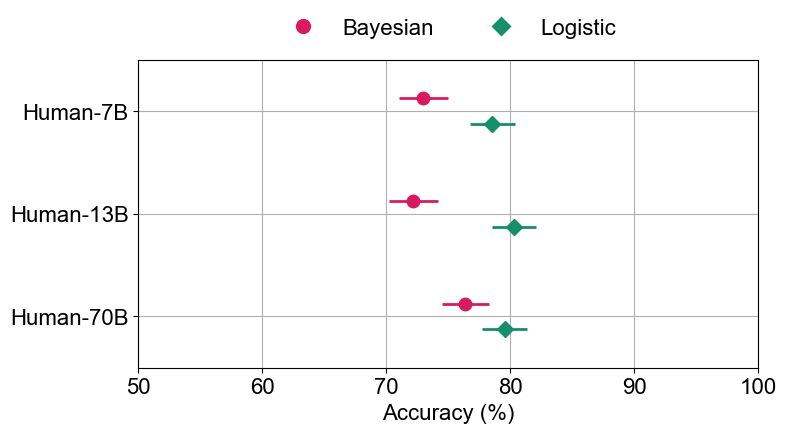

In [6]:
# Define custom colors for each type
mycolors  = {'Bayesian': '#D81B60', 'Logistic': '#158E6B'}
mymarkers = {'Bayesian': 'o',       'Logistic': 'D'}
mymarksze = {'Bayesian': 9,         'Logistic': 8}

# Plot Figure 4
plot_figure(df2, mycolors, mymarkers, mymarksze)